<a href="https://colab.research.google.com/github/SuhaasAdiraju/NeuromatchAcademy2023_SSA/blob/main/tutorials/W1D5_DeepLearning/student/W1D5_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Decoding Neural Responses

**Week 1, Day 5: Deep Learning**

**By Neuromatch Academy**

**Content creators**: Jorge A. Menendez, Carsen Stringer

**Content reviewers**: Roozbeh Farhoodi,  Madineh Sarvestani, Kshitij Dwivedi, Spiros Chavlis, Ella Batty, Michael Waskom

**Production editors:** Spiros Chavlis

---
# Tutorial Objectives

*Estimated timing of tutorial: 1 hr, 20 minutes*

In this tutorial, we'll use deep learning to decode stimulus information from the responses of sensory neurons. Specifically, we'll look at the activity of ~20,000 neurons in the mouse primary visual cortex responding to oriented gratings recorded in [this study](https://www.biorxiv.org/content/10.1101/679324v2.abstract). Our task will be to decode the orientation of the presented stimulus from the responses of the whole population of neurons. We could do this in a number of ways, but here we'll use deep learning. Deep learning is particularly well-suited to this problem for a number of reasons:
* The data are very high-dimensional: the neural response to a stimulus is a ~20,000 dimensional vector. Many machine learning techniques fail in such high dimensions, but deep learning actually thrives in this regime, as long as you have enough data (which we do here!).
* As you'll be able to see below, different neurons can respond quite differently to stimuli. This complex pattern of responses will, therefore, require non-linear methods to be decoded, which we can easily do with non-linear activation functions in deep networks.
* Deep learning architectures are highly flexible, meaning we can easily adapt the architecture of our decoding model to optimize decoding. Here, we'll focus on a single architecture, but you'll see that it can easily be modified with few changes to the code.

More concretely, our goal will be learn how to:
* Build a deep feed-forward network using PyTorch
* Evaluate the network's outputs using PyTorch built-in loss functions
* Compute gradients of the loss with respect to each parameter of the network using automatic differentiation
* Implement gradient descent to optimize the network's parameters

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for all videos in this tutorial.
from IPython.display import IFrame
link_id = "vb7c4"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup


In [ ]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W1D5_T1"

In [1]:
# Imports
import os
import numpy as np

import torch
from torch import nn
from torch import optim

import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Plotting Functions

def plot_data_matrix(X, ax, show=False):
  """Visualize data matrix of neural responses using a heatmap

  Args:
    X (torch.Tensor or np.ndarray): matrix of neural responses to visualize
        with a heatmap
    ax (matplotlib axes): where to plot
    show (boolean): enable plt.show()

  """

  cax = ax.imshow(X, cmap=mpl.cm.pink, vmin=np.percentile(X, 1),
                  vmax=np.percentile(X, 99))
  cbar = plt.colorbar(cax, ax=ax, label='normalized neural response')

  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])
  if show:
    plt.show()


def plot_train_loss(train_loss):
  plt.plot(train_loss)
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.xlabel('iterations of gradient descent')
  plt.ylabel('mean squared error')
  plt.show()

In [4]:
# @title Helper Functions

def load_data(data_name, bin_width=1):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaging. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. They have also been binned and averaged
  to each degree of orientation.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  This function will actually average responses to stimuli with orientations
  falling within bins specified by the bin_width argument. This helps
  produce individual neural "responses" with smoother and more
  interpretable tuning curves.

  Args:
    bin_width (float): size of stimulus bins over which to average neural
      responses

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp = data['resp']
  stimuli = data['stimuli']

  if bin_width > 1:
    # Bin neural responses and stimuli
    bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
    stimuli_binned = np.array([stimuli[bins == i].mean() for i in np.unique(bins)])
    resp_binned = np.array([resp[bins == i, :].mean(0) for i in np.unique(bins)])
  else:
    resp_binned = resp
    stimuli_binned = stimuli

  # Return as torch.Tensor
  resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

  return resp_tensor, stimuli_tensor


def get_data(n_stim, train_data, train_labels):
  """ Return n_stim randomly drawn stimuli/resp pairs

  Args:
    n_stim (scalar): number of stimuli to draw
    resp (torch.Tensor):
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians

  Returns:
    (torch.Tensor, torch.Tensor): n_stim x n_neurons tensor of neural responses and n_stim x 1 of orientations respectively
  """
  n_stimuli = train_labels.shape[0]
  istim = np.random.choice(n_stimuli, n_stim)
  r = train_data[istim]  # neural responses to this stimulus
  ori = train_labels[istim]  # true stimulus orientation

  return r, ori

In [5]:
# @title Data retrieval and loading
import hashlib
import requests

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

---
# Section 0: Decoding Task

The following video covers the decoding task we will use in these tutorials, a linear network with one hidden layer, and how to build this in PyTorch.

Generalized linear models were used as decoding and encoding models in [Generalized Linear Model Day](https://compneuro.neuromatch.io/tutorials/W1D3_GeneralizedLinearModels/chapter_title.html). A model that decodes a variable from neural activity can tell us *how much information* a brain area contains about that variable. An encoding model is a model from an input variable, like visual stimulus, to neural activity. The encoding model is meant to approximate the same transformation that the brain performs on input variables and therefore help us understand *how the brain represents information*. Today we will use deep neural networks to build these models because deep neural networks can approximate a wide range of non-linear functions and can be easily fit.

In [ ]:
# @title Video 1: Decoding from neural data using feed-forward networks in pytorch
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'SlrbMvvBOzM'), ('Bilibili', 'BV1Xa4y1a7Jz')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Decoding_from_neural_data_Video")

---
# Section 1: Load, split and visualize data

<details>
<summary> <font color='blue'>Click here for text recap of relevant part of  video </font></summary>

We will be exploring neural activity in mice while the mice is viewing oriented grating stimuli on a screen in front of it. We record neural activity using a technique called two-photon calcium imaging, which allows us to record many thousands of neurons simultanously. The neurons light up when they fire. We then convert this imaging data to a matrix of neural responses by stimuli presented. For the purposes of this tutorial we are going to bin the neural responses and compute each neuron’s tuning curve. We used bins of 1 degree. We will use the response of all neurons in a single bin to try to predict which stimulus was shown. So we are going to be using the responses of 24000 neurons to try to predict 360 different possible stimulus conditions corresponding to each degree of orientation - which means we're in the regime of big data!

</details>

In the next cell, we have provided code to load the data and plot the matrix of neural responses.

Next to it, we plot the tuning curves of three randomly selected neurons. These tuning curves are the averaged response of each neuron to oriented stimuli within 1$^\circ$, and since there are 360$^\circ$ in total, we have 360 responses.

In the recording, there were actually thousands of stimuli shown, but in practice we often create these tuning curves because we want to visualize averaged responses with respect to the variable we varied in the experiment, in this case stimulus orientation.

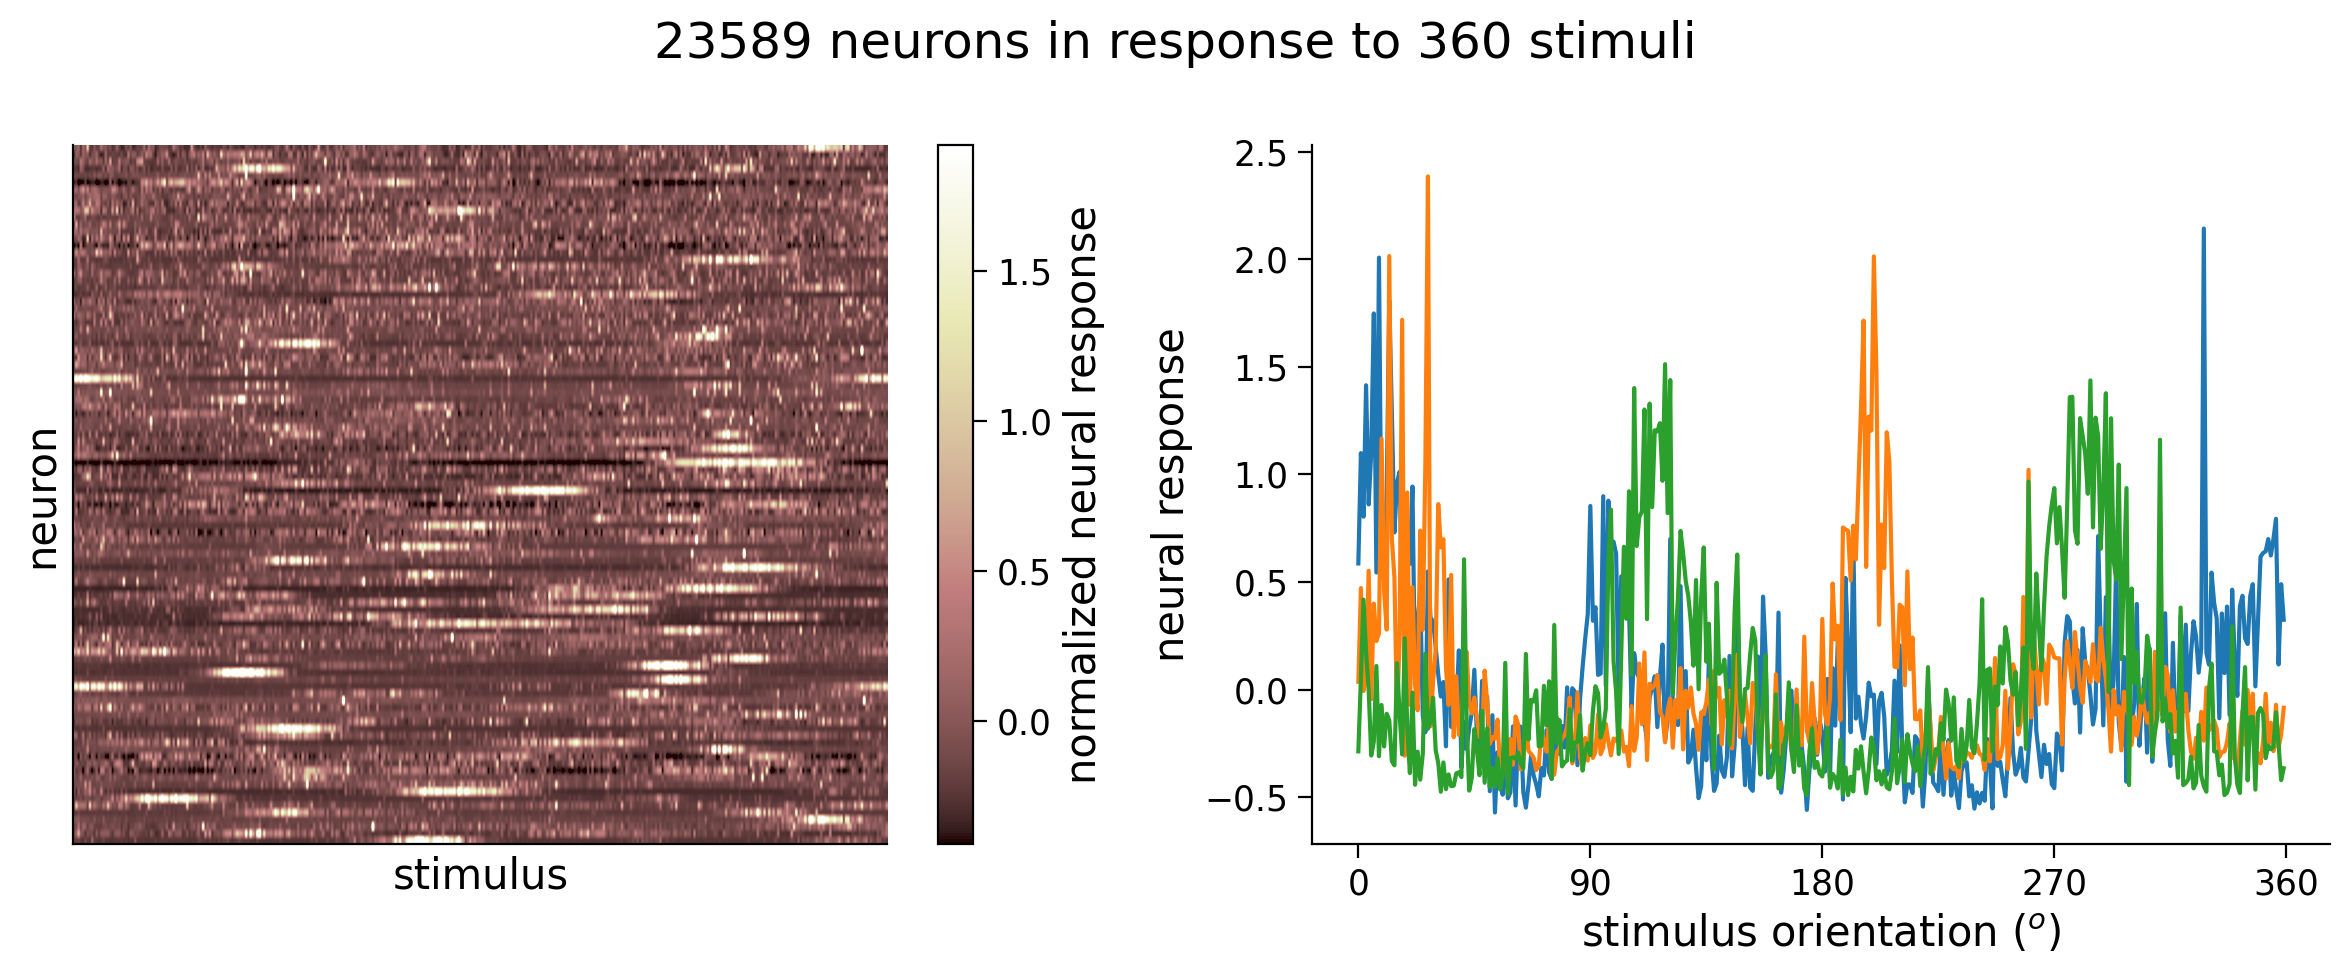

In [6]:
# @markdown Execute this cell to load and visualize data

# Load data
resp_all, stimuli_all = load_data(fname)  # argument to this function specifies bin width
n_stimuli, n_neurons = resp_all.shape

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6, 5))

# Visualize data matrix
plot_data_matrix(resp_all[:, :100].T, ax1)  # plot responses of first 100 neurons
ax1.set_xlabel('stimulus')
ax1.set_ylabel('neuron')

# Plot tuning curves of three random neurons
ineurons = np.random.choice(n_neurons, 3, replace=False)  # pick three random neurons
ax2.plot(stimuli_all, resp_all[:, ineurons])
ax2.set_xlabel('stimulus orientation ($^o$)')
ax2.set_ylabel('neural response')
ax2.set_xticks(np.linspace(0, 360, 5))

fig.suptitle(f'{n_neurons} neurons in response to {n_stimuli} stimuli')
fig.tight_layout()
plt.show()

We will split our data into a training set and test set. In particular, we will have a training set of orientations (`stimuli_train`) and the corresponding responses (`resp_train`). Our testing set will have held-out orientations (`stimuli_test`) and the corresponding responses (`resp_test`).

In [20]:
# @markdown Execute this cell to split into training and test sets

# Set random seeds for reproducibility
np.random.seed(4)
torch.manual_seed(4)

# Split data into training set and testing set
n_train = int(0.6 * n_stimuli)  # use 60% of all data for training set
ishuffle = torch.randperm(n_stimuli)
itrain = ishuffle[:n_train]  # indices of data samples to include in training set
itest = ishuffle[n_train:]  # indices of data samples to include in testing set
stimuli_test = stimuli_all[itest]; np.shape(stimuli_all)
resp_test = resp_all[itest]
stimuli_train = stimuli_all[itrain]
resp_train = resp_all[itrain]

torch.Size([360, 1])

---
# Section 2: Deep feed-forward networks in *pytorch*


<details>
<summary> <font color='blue'>Click here for text recap of relevant part of video </font></summary>

We can build a linear network with no hidden layers, where the stimulus prediction $y$ is a product of weights $\mathbf{W}_{out}$ and neural responses $\mathbf{r}$ with an added term $\mathbf{b}$ which is called the bias term. When you fit a linear model such as this you minimize the squared error between the predicted stimulus $y$ and the true stimulus $\tilde{y}$, this is the “loss function”.

\begin{align}
L &= (y - \tilde{y})^2 \\
&= ((\mathbf{W}^{out} \mathbf{r} + \mathbf{b}) - \tilde{y})^2
\end{align}

The solution to minimizing this loss function in a linear model can be found in closed form, and you learned how to solve this linear regression problem in the first week if you remember. If we use a simple linear model for this data we are able to predict the stimulus within 2-3 degrees. Let’s see if we can predict the neural activity better with a deep network.

Let’s add a hidden layer with $M$ units to this linear model, where now the output $y$ is as follows:
\begin{align}
\mathbf{h} &= \mathbf{W}^{in} \mathbf{r} + \mathbf{b}^{in}, && [\mathbf{W}^{in}: M \times N \, , \, \mathbf{b}^{in}: M \times 1] \, , \\
y &= \mathbf{W}^{out} \mathbf{h} + \mathbf{b}^{out},  && [\mathbf{W}^{out}: 1 \times M\, , \, \mathbf{b}^{in}: 1 \times 1] \, ,
\end{align}


Note this linear network with one hidden layer where $M$ hidden units is less than $N$ inputs is equivalent to performing [reduced rank regression](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3444519/), a technique that is useful for regularizing your regression model.

Adding this hidden layer means the model now has a depth of $1$. The number of units $M$ is termed the width of the network. Increasing the depth and the width of the network can increase the expressivity of the model -- in other words how well it can fit complex non-linear functions. Many state-of-the-art models now have close to 100 layers! But for now let’s start with a model with a depth of $1$ and see if we can improve our prediction of the stimulus.  See [bonus section 1](#b1) for a deeper discussion of what this choice entails, and when one might want to use deeper/shallower and wider/narrower architectures.

The $M$-dimensional vector $\mathbf{h}$ denotes the activations of the **hidden layer** of the network. The blue components of this diagram denote the **parameters** of the network, which we will later optimize with gradient descent. These include all the weights and biases $\mathbf{W}^{in}, \mathbf{b}^{in}, \mathbf{W}^{out}, \mathbf{b}^{out}$. The **weights** are matrices of size (# of outputs, # of inputs) that are multiplied by the input of each layer, like the regression coefficients in linear regression. The **biases** are vectors of size (# of outputs, 1), like the intercept term in linear regression (see W1D3 for more details on multivariate linear regression).

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/main/tutorials/static/one-layer-network.png?raw=true" width="450" />
</p>

</details>

We'll now build a simple deep neural network that takes as input a vector of neural responses and outputs a single number representing the decoded stimulus orientation.

Let $\mathbf{r}^{(n)} = \begin{bmatrix} r_1^{(n)} & r_2^{(n)} & \ldots & r_N^{(n)} \end{bmatrix}^\top$ denote the vector of neural responses (of neurons $1, \ldots, N$) to the $n$th stimulus. The network we will use is described by the following set of equations:

\begin{align}
\mathbf{h}^{(n)} &= \mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in}, && [\mathbf{W}^{in}: M \times N \, , \, \mathbf{b}^{in}: M \times 1] \, , \\
y^{(n)} &= \mathbf{W}^{out} \mathbf{h}^{(n)} + \mathbf{b}^{out},  && [\mathbf{W}^{out}: 1 \times M \, , \, \mathbf{b}^{in}: 1 \times 1] \, ,
\end{align}

where $y^{(n)}$ denotes the scalar output of the network: the decoded orientation of the $n$-th stimulus.

### Section 2.1: Introduction to PyTorch

*Estimated timing to here from start of tutorial:  16 min*

Here, we'll use the **PyTorch** package to build, run, and train deep networks of this form in Python. PyTorch uses a data type called a `torch.Tensor`. They are effectively just like `numpy` arrays, except that they have some important attributes and methods needed for automatic differentiation (to be discussed below). They also come along with infrastructure for easily storing and computing with them on GPU's, a capability we won't touch on here but which can be really useful in practice.

<details>
<summary> <font color='blue'>Click here for text recap of relevant part of video </font></summary>

First we import the pytorch library called `torch` and its neural network module `nn`. Next we will create a class for the deep network called DeepNet. A class has functions which are called methods. A class in python is initialized using a method called `__init__`. In this case the init method is declared to takes two inputs (other than the `self` input which represents the class itself), which are `n_inputs` and `n_hidden`. In our case `n_inputs` is the number of neurons we are using to do the prediction, and `n_hidden` is the number of hidden units. We first call the super function to invoke the `nn.Module`’s init function. Next we add the hidden layer `in_layer` as an attribute of the class. It is a linear layer called `nn.Linear` with size `n_inputs` by `n_hidden`. Then we add a second linear layer `out_layer` of size `n_hidden` by `1`, because we are predicting one output - the orientation of the stimulus. PyTorch will initialize all weights and biases randomly.

Note the number of hidden units `n_hidden` is a parameter that we are free to vary in deciding how to build our network. See [Bonus Section 1](#b1) for a discussion of how this architectural choice affects the computations the network can perform.

Next we add another method to the class called `forward`. This is the method that runs when you call the class as a function. It takes as input `r` which is the neural responses. Then `r` is sent through the linear layers `in_layer` and `out_layer` and returns our prediction `y`. Let’s create an instantiation of this class called `net` with 200 hidden units with `net = DeepNet(n_neurons, 200)`. Now we can run the neural response through the network to predict the stimulus (`net(r)`); running the “net” this way calls the forward method.


</details>

The next cell contains code for building the deep network we defined above and in the video using the `nn.Module` base class for deep neural network models (documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=nn%20module#torch.nn.Module)).

In [12]:
class DeepNet(nn.Module):
  """Deep Network with one hidden layer

  Args:
    n_inputs (int): number of input units
    n_hidden (int): number of units in hidden layer

  Attributes:
    in_layer (nn.Linear): weights and biases of input layer
    out_layer (nn.Linear): weights and biases of output layer

  """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):
    """Decode stimulus orientation from neural responses

    Args:
      r (torch.Tensor): vector of neural responses to decode, must be of
        length n_inputs. Can also be a tensor of shape n_stimuli x n_inputs,
        containing n_stimuli vectors of neural responses

    Returns:
      torch.Tensor: network outputs for each input provided in r. If
        r is a vector, then y is a 1D tensor of length 1. If r is a 2D
        tensor then y is a 2D tensor of shape n_stimuli x 1.

    """
    h = self.in_layer(r)  # hidden representation
    y = self.out_layer(h)
    return y

## Section 2.2: Activation functions

*Estimated timing to here from start of tutorial: 25 min*

In [ ]:
# @title Video 2: Nonlinear activation functions
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'JAdukDCQALA'), ('Bilibili', 'BV1m5411h7V5')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Nonlinear_activation_functions_Video")

This video covers adding a nonlinear activation function, specifically a Rectified Linear Unit (ReLU), to the linear network.

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

Note that the deep network we constructed above comprises solely **linear** operations on each layer: each layer is just a weighted sum of all the elements in the previous layer. It turns out that linear hidden layers like this aren't particularly useful, since a sequence of linear transformations is actually essentially the same as a single linear transformation. We can see this from the above equations by plugging in the first one into the second one to obtain

\begin{equation}
y^{(n)} = \mathbf{W}^{out} \left( \mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in} \right) + \mathbf{b}^{out} = \mathbf{W}^{out}\mathbf{W}^{in} \mathbf{r}^{(n)} + \left( \mathbf{W}^{out}\mathbf{b}^{in} + \mathbf{b}^{out} \right)
\end{equation}

In other words, the output is still just a weighted sum of elements in the input -- the hidden layer has done nothing to change this.

To extend the set of computable input/output transformations to more than just weighted sums, we'll incorporate a **non-linear activation function** in the hidden units. This is done by simply modifying the equation for the hidden layer activations to be

\begin{equation}
\mathbf{h}^{(n)} = \phi(\mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in})
\end{equation}

where $\phi$ is referred to as the activation function. Using a non-linear activation function will ensure that the hidden layer performs a non-linear transformation of the input, which will make our network much more powerful (or *expressive*, see [Bonus Section 1](#b1)). In practice, deep networks *always* use non-linear activation functions.

The most common non-linearity used is the rectified linear unit (or ReLU), which is a max(0, x) function. At the beginning of neural network development, researchers experimented with different non-linearities such as sigmoid and tanh functions, but in the end they found that RELU activation functions worked the best. It works well because the gradient is able to back-propagate through the network as long as the input is positive - the gradient is 1 for all values of x greater than 0. If you use a saturating non-linearity then the gradients will be very small in the saturating regimes, reducing the effective computing regime of the unit.

</details>


#### Coding Exercise 2.2: Nonlinear Activations

Create a new class `DeepNetReLU` by modifying our above deep network model to add a **non-linear activation** function $\phi$:
\begin{equation}
\mathbf{h}^{(n)} = \phi(\mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in})
\end{equation}

We'll use the linear rectification function:

\begin{equation}
\phi(x) =
\begin{cases}
x & \text{if } x > 0 \\
0 & \text{else}
\end{cases}
\end{equation}

which can be implemented in PyTorch using `torch.relu()`. Hidden layers with this activation function are typically referred to as "**Re**ctified **L**inear **U**nits", or **ReLU**'s.

Initialize this network with 10 hidden units and run on an example stimulus.

**Hint**: you only need to modify the `forward()` method of the above `DeepNet()` class to include `torch.relu()`.

<br>

We then initialize and run this network. We use it to decode stimulus orientation (true stimulus given by `ori`) from a vector of neural responses `r` to the very first stimulus. Note that when the initialized network class is called as a function on an input (e.g., `net(r)`), its `.forward()` method is called. This is a special property of the `nn.Module` class.

Note that the decoded orientations at this point will be nonsense, since the network has been initialized with random weights. Below, we'll learn how to optimize these weights for good stimulus decoding.

In [21]:
class DeepNetReLU(nn.Module):
  """ network with a single hidden layer h with a RELU """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):

    ############################################################################
    ## TO DO for students: write code for computing network output using a
    ## rectified linear activation function for the hidden units
    # Fill out function and remove
        #raise NotImplementedError("Student exercise: complete DeepNetReLU forward")
    ############################################################################

    h = torch.relu(self.in_layer(r)) # h is size (n_inputs, n_hidden)
    y = self.out_layer(h) # y is size (n_inputs, 1)


    return y


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=200 hidden units
net = DeepNetReLU(n_neurons, 200)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)  # using helper function get_data

# Decode orientation from these neural responses using initialized network
out = net(r)  # compute output from network, equivalent to net.forward(r)

print(f'decoded orientation: {out.item():.2f} degrees')
print(f'true orientation: {ori.item():.2f} degrees')

decoded orientation: 0.17 degrees
true orientation: 139.00 degrees


The decoded orientation is 0.17 $^{\circ}$ while the true orientation is 139.00 $^{\circ}$. You should see:
```
decoded orientation: 0.17 degrees
true orientation: 139.00 degrees
```

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D5_DeepLearning/solutions/W1D5_Tutorial1_Solution_6bfd6123.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Nonlinear_activations_Exercise")

---
# Section 3: Loss functions and gradient descent


In [ ]:
# @title Video 3: Loss functions & gradient descent
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'aEtKpzEuviw'), ('Bilibili', 'BV19k4y1271n')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Loss_functions_and_gradient_descent_Video")

This video covers loss functions, gradient descent, and how to implement these in Pytorch.




### Section 3.1: Loss functions

*Estimated timing to here from start of tutorial: 40 min*

Because the weights of the network are currently randomly chosen, the outputs of the network are nonsense: the decoded stimulus orientation is nowhere close to the true stimulus orientation. We'll shortly write some code to change these weights so that the network does a better job of decoding.

But to do so, we first need to define what we mean by "better". One simple way of defining this is to use the squared error

\begin{equation}
L = (y - \tilde{y})^2
\end{equation}

where $y$ is the network output and $\tilde{y}$ is the true stimulus orientation. When the decoded stimulus orientation is far from the true stimulus orientation, $L$ will be large. We thus refer to $L$ as the **loss function**, as it quantifies how *bad* the network is at decoding stimulus orientation.

<details>
<summary> <font color='blue'>Click here for text recap of relevant part of video </font></summary>

First we run the neural responses through the network `net` to get the output `out`. Then we declare our loss function, we will use the built in `nn.MSELoss` function for this purpose: `loss_fn = nn.MSELoss()`. This loss function takes two inputs, the network output `out` and the true stimulus orientations `ori` and finds the mean squared error: `loss = loss_fn(out, ori)`.  Specifically, it will take as arguments a **batch** of network outputs $y_1, y_2, \ldots, y_P$ and corresponding target outputs $\tilde{y}_1, \tilde{y}_2, \ldots, \tilde{y}_P$, and compute the **mean squared error (MSE)**

\begin{equation}
L = \frac{1}{P}\sum_{n=1}^P \left(y^{(n)} - \tilde{y}^{(n)}\right)^2
\end{equation}

where $P$ is the number of different stimuli in a batch, called the *batch size*.

**Computing MSE**


Evaluate the mean squared error for a deep network with $M=10$ rectified linear units, on the decoded orientations from neural responses to 20 random stimuli.

In [23]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=10 hidden units
net = DeepNetReLU(n_neurons, 10)

# Get neural responses to first 20 stimuli in the data set
r, ori = get_data(20, resp_train, stimuli_train)

# Decode orientation from these neural responses
out = net(r)

# Initialize PyTorch mean squared error loss function (Hint: look at nn.MSELoss)
loss_fn = nn.MSELoss()

# Evaluate mean squared error
loss = loss_fn(out, ori)

print(f'mean squared error: {loss:.2f}')

mean squared error: 42949.14


You should see a mean squared error of 42949.14.

### Section 3.2: Optimization with gradient descent
*Estimated timing to here from start of tutorial: 50 min*

<details>
<summary> <font color='blue'>Click here for text recap of relevant part of video </font></summary>


Next we minimize this loss function using gradient descent. In **gradient descent** we compute the gradient of the loss function with respect to each parameter (all $W$’s and $b$’s). We then update the parameters by subtracting the learning rate times the gradient.

Let’s visualize this loss function $L$ with respect to a weight $w$. If the gradient is positive (the slope $\frac{dL}{dw}$ > 0) as in this case then we want to move in the opposite direction which is negative. So we update the $w$ accordingly in the negative direction on each iteration. Once the iterations complete the weight will ideally be at a value that minimizes the cost function.

In reality these cost functions are not convex like this one and depend on hundreds of thousands of parameters. There are tricks to help navigate this rocky cost landscape such as adding momentum or changing the optimizer but we won’t have time to get into that today. There are also ways to change the architecture of the network to improve optimization, such as including skip connections. These skip connections are used in residual networks and allow for the optimization of many layer networks.

</details>

In [22]:
# @markdown Execute this cell to view gradient descent gif

from IPython.display import Image
Image(url='https://github.com/NeuromatchAcademy/course-content/blob/main/tutorials/static/grad_descent.gif?raw=true')

We'll use the **gradient descent (GD)** algorithm to modify our weights to reduce the loss function, which consists of iterating three steps.

1. **Evaluate the loss** on the training data,
```python
out = net(train_data)
loss = loss_fn(out, train_labels)
```
where `train_data` are the network inputs in the training data (in our case, neural responses), and `train_labels` are the target outputs for each input (in our case, true stimulus orientations).
2. **Compute the gradient of the loss** with respect to each of the network weights. In PyTorch, we can do this with the `.backward()` method of the loss `loss`. Note that the gradients of each parameter need to be cleared before calling `.backward()`, or else PyTorch will try to accumulate gradients across iterations. This can again be done using built-in optimizers via the method `.zero_grad()`. Putting these together we have
```python
optimizer.zero_grad()
loss.backward()
```
3. **Update the network weights** by descending the gradient. In Pytorch, we can do this using built-in optimizers. We'll use the `optim.SGD` optimizer (documentation [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)) which updates parameters along the negative gradient, scaled by a learning rate. To initialize this optimizer, we have to tell it
  * which parameters to update, and
  * what learning rate to use

  For example, to optimize *all* the parameters of a network `net` using a learning rate of .001, the optimizer would be initialized as follows
  ```python
  optimizer = optim.SGD(net.parameters(), lr=.001)
  ```
  where `.parameters()` is a method of the `nn.Module` class that returns a [Python generator object](https://wiki.python.org/moin/Generators) over all the parameters of that `nn.Module` class (in our case, $\mathbf{W}^{in}, \mathbf{b}^{in}, \mathbf{W}^{out}, \mathbf{b}^{out}$).

  After computing all the parameter gradients in step 2, we can then update each of these parameters using the `.step()` method of this optimizer,
  ```python
  optimizer.step()
  ```
In the next exercise, we'll give you a code skeleton for implementing the GD algorithm. Your job will be to fill in the blanks.

For the mathematical details of the GD algorithm, see [bonus section 2.1](#b21).

In this case we are using gradient descent (not *stochastic* gradient descent) because we are computing the gradient over ALL training data at once. Normally there is too much training data to do this in practice, and for instance the neural responses may be divided into sets of 20 stimuli. An **epoch** in deep learning is defined as the forward and backward pass of all the training data through the network. We will run the forward and backward pass of the network here for 20 **epochs**, in practice training may require thousands of epochs.

See [bonus section 2.2](#b22) for a more detailed discussion of stochastic gradient descent.

#### Coding Exercise 3.2: Gradient descent in PyTorch

Complete the function `train()` that uses the gradient descent algorithm to optimize the weights of a given network. This function takes as input arguments
* `net`: the PyTorch network whose weights to optimize
* `loss_fn`: the PyTorch loss function to use to evaluate the loss
* `train_data`: the training data to evaluate the loss on (i.e., neural responses to decode)
* `train_labels`: the target outputs for each data point in `train_data` (i.e., true stimulus orientations)

We will then train a neural network on our data and plot the loss (mean squared error) over time. When we run this function, behind the scenes PyTorch is actually changing the parameters inside this network to make the network better at decoding, so its weights will now be different than they were at initialization.

iteration 10/50 | loss: 12219.759
iteration 20/50 | loss: 1672.732
iteration 30/50 | loss: 548.097
iteration 40/50 | loss: 235.619
iteration 50/50 | loss: 144.001


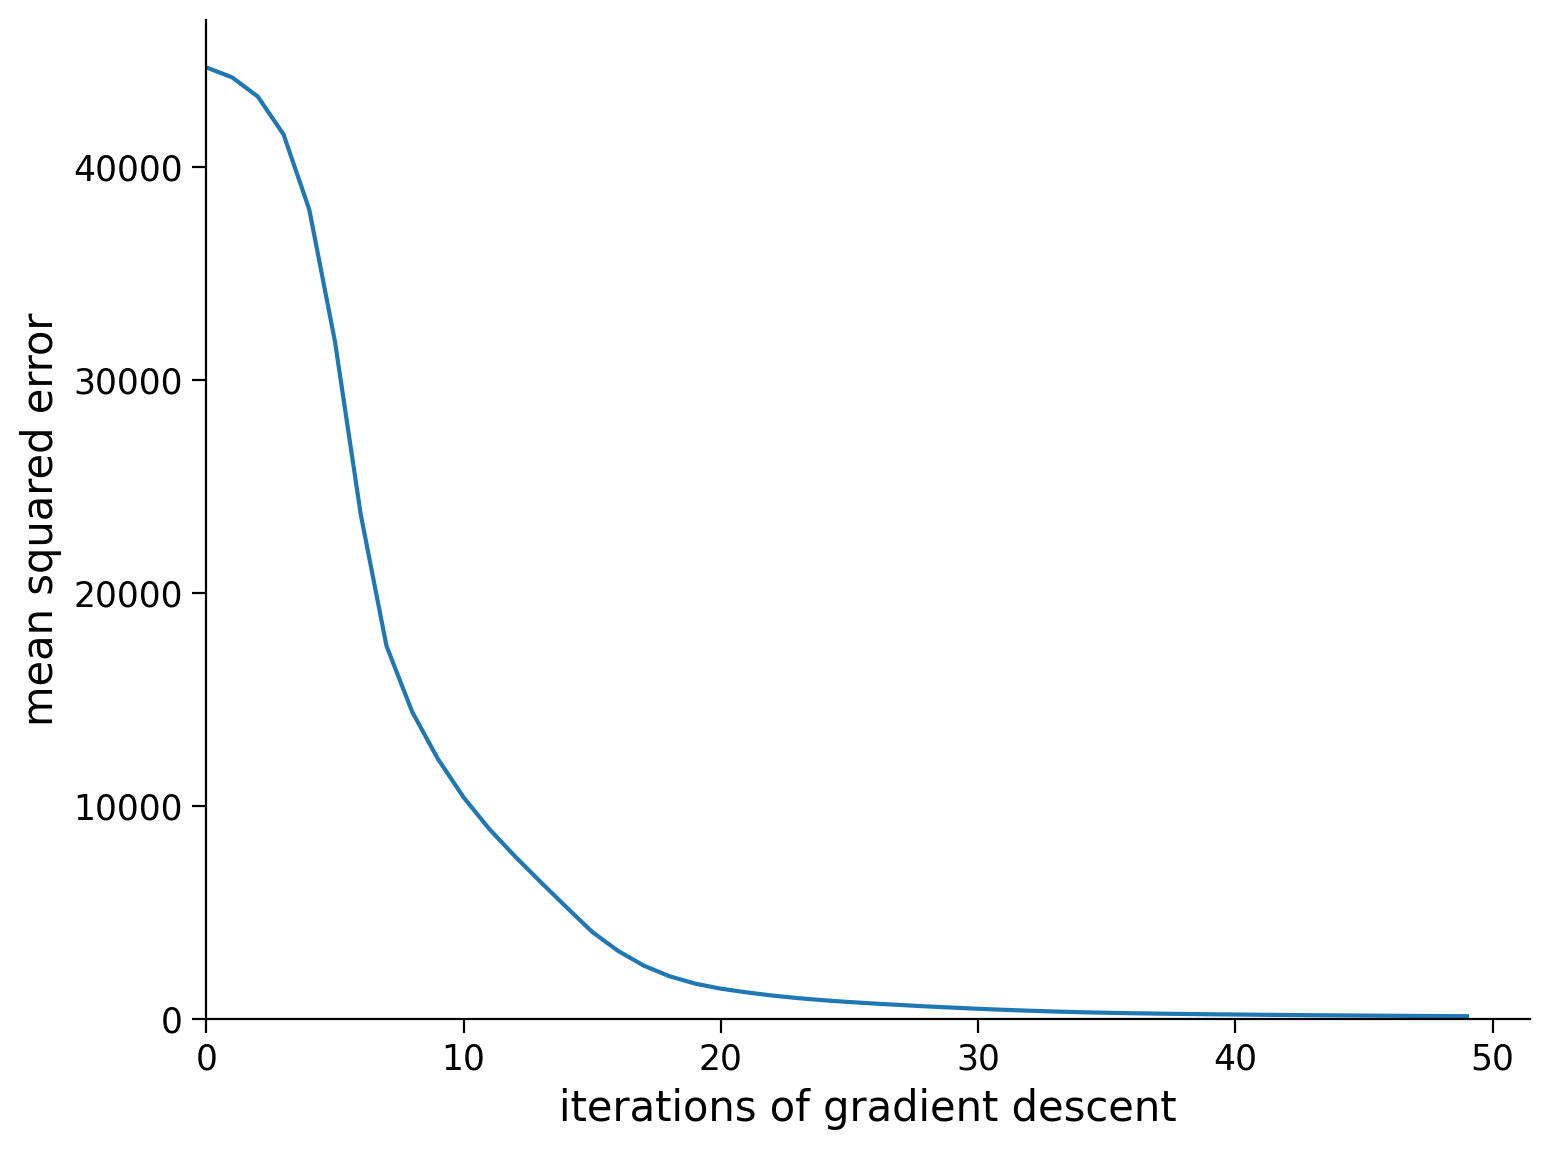

In [28]:
def train(net, loss_fn, train_data, train_labels,
          n_epochs=50, learning_rate=1e-4):
  """Run gradient descent to optimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data
    n_epochs (int, optional): number of epochs of gradient descent to run
    learning_rate (float, optional): learning rate to use for gradient descent

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []

  # Loop over epochs
  for i in range(n_epochs):

    ######################################################################
    ## TO DO for students: fill in missing code for GD iteration
        #raise NotImplementedError("Student exercise: write code for GD iterations")
    ######################################################################

    # compute network output from inputs in train_data
    out = net(train_data) # compute network output from inputs in train_data

    # evaluate loss function
    loss = loss_fn(out, train_labels)

    # Clear previous gradients
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Track progress
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')

  return train_loss


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize network with 10 hidden units
net = DeepNetReLU(n_neurons, 10)

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.MSELoss()

# Run gradient descent on data
train_loss = train(net, loss_fn, resp_train, stimuli_train)

# Plot the training loss over iterations of GD
plot_train_loss(train_loss)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D5_DeepLearning/solutions/W1D5_Tutorial1_Solution_1ca16188.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D5_DeepLearning/static/W1D5_Tutorial1_Solution_1ca16188_3.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Gradient_descent_in_Pytorch_Exercise")

We can further improve our model - please see the **Bonus** part of the Tutorial when you have time to dive deeper into this model by evaluating and improving its performance by visualizing the weights, looking at performance on test data, switching to a new loss function and adding regularization.

---
# Summary

*Estimated timing of tutorial: 1 hour, 20 minutes*

We have now covered a number of common and powerful techniques for applying deep learning to decoding from neural data, some of which are common to almost any machine learning problem:
* Building and training deep networks using the **PyTorch** `nn.Module` class and built-in **optimizers**
* Choosing **loss functions**

An important aspect of this tutorial was the `train()` function we wrote in coding exercise 3.2. Note that it can be used to train *any* network to minimize *any* loss function on *any* training data. This is the power of using PyTorch to train neural networks and, for that matter, **any other model**! There is nothing in the `nn.Module` class that forces us to use `nn.Linear` layers that implement neural network operations. You can actually put anything you want inside the `.__init__()` and `.forward()` methods of this class. As long as its parameters and computations involve only `torch.Tensor`'s, and the model is differentiable, you'll then be able to optimize the parameters of this model in exactly the same way we optimized the deep networks here.

What kinds of conclusions can we draw from these sorts of analyses? If we can decode the stimulus well from visual cortex activity, that means that there is information about this stimulus available in the visual cortex. Whether or not the animal uses that information to make decisions is not determined from an analysis like this. In fact mice perform poorly in orientation discrimination tasks compared to monkeys and humans, even though they have information about these stimuli in their visual cortex. Why do you think they perform poorly in orientation discrimination tasks?

See [Stringer, _et al._, 2021](https://doi.org/10.1016/j.cell.2021.03.042) for some potential hypotheses, but this is totally an open question!

---
# Bonus

<a name='b1'></a>
## Bonus Section 1: Neural network *depth*, *width* and *expressivity*

Two important architectural choices that always have to be made when constructing deep feed-forward networks like those used here are
* the number of hidden layers, or the network's *depth*
* the number of units in each layer, or the layer *widths*

Here, we restricted ourselves to networks with a single hidden layer with a width of $M$ units, but it is easy to see how this code could be adapted to arbitrary depths. Adding another hidden layer simply requires adding another `nn.Linear` module to the `__init__()` method and incorporating it into the `.forward()` method.

The depth and width of a network determine the set of input/output transformations that it can perform, often referred to as its *expressivity*. The deeper and wider the network, the more *expressive* it is; that is, the larger the class of input/output transformations it can compute. In fact, it turns out that an infinitely wide *or* infinitely deep networks can in principle [compute (almost) *any* input/output transformation](https://en.wikipedia.org/wiki/Universal_approximation_theorem).

A classic mathematical demonstration of the power of depth is given by the so-called [XOR problem](https://medium.com/@jayeshbahire/the-xor-problem-in-neural-networks-50006411840b#:~:text=The%20XOr%2C%20or%20%E2%80%9Cexclusive%20or,value%20if%20they%20are%20equal.). This toy problem demonstrates how even a single hidden layer can drastically expand the set of input/output transformations a network can perform, relative to a shallow network with no hidden layers. The key intuition is that the hidden layer allows you to represent the input in a new format, which can then allow you to do almost anything you want with it. The *wider* this hidden layer, the more flexibility you have in this representation. In particular, if you have more hidden units than input units, then the hidden layer representation of the input is higher-dimensional than the raw data representation. This higher dimensionality effectively gives you more "room" to perform arbitrary computations in. It turns out that even with just this one hidden layer, if you make it wide enough you can actually approximate any input/output transformation you want. See [here](http://neuralnetworksanddeeplearning.com/chap4.html) for a neat visual demonstration of this.

In practice, however, it turns out that increasing depth seems to grant more expressivity with fewer units than increasing width does (for reasons that are not well understood). It is for this reason that truly *deep* networks are almost always used in machine learning, which is why this set of techniques is often referred to as *deep* learning.

That said, there is a cost to making networks deeper and wider. The bigger your network, the more parameters (i.e., weights and biases) it has, which need to be optimized! The extra expressivity afforded by higher width and/or depth thus carries with it (at least) two problems:
* optimizing more parameters usually requires more data
* a more highly parameterized network is more prone to overfit to the training data, so requires more sophisticated optimization algorithms to ensure generalization

## Bonus Section 2: Gradient descent

<a name='b21'></a>
### Bonus Section 2.1: Gradient descent equations

Here we provide the equations for the three steps of the gradient descent algorithm, as applied to our decoding problem:

1. **Evaluate the loss** on the training data. For a mean squared error loss, this is given by

\begin{equation}
L = \frac{1}{P}\sum_{n=1}^P \left( y^{(n)} - \tilde{y}^{(n)} \right)^2
\end{equation}

where $y^{(n)}$ denotes the stimulus orientation decoded from the population response $\mathbf{r}^{(n)}$ to the $n$th stimulus in the training data, and $\tilde{y}^{(n)}$ is the true orientation of that stimulus. $P$ denotes the total number of data samples in the training set. In the syntax of our `train()` function above, $\mathbf{r}^{(n)}$ is given by `train_data[n, :]` and $\tilde{y}^{(n)}$ by `train_labels[n]`.

2. **Compute the gradient of the loss** with respect to each of the network weights. In our case, this entails computing the quantities

\begin{equation}
\frac{\partial L}{\partial \mathbf{W}^{in}}, \frac{\partial L}{\partial \mathbf{b}^{in}}, \frac{\partial L}{\partial \mathbf{W}^{out}}, \frac{\partial L}{\partial \mathbf{b}^{out}}
\end{equation}

Usually, we would require lots of math in order to derive each of these gradients, and lots of code to compute them. But this is where PyTorch comes to the rescue! Using a cool technique called [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), PyTorch automatically calculates these gradients when the `.backward()` function is called.

More specifically, when this function is called on a particular variable (e.g., `loss`, as above), PyTorch will compute the gradients with respect to each network parameter. These are computed and stored behind the scenes, and can be accessed through the `.grad` attribute of each of the network's parameters. As we saw above, however, we actually never need to look at or call these gradients when implementing gradient descent, as this can be taken care of by PyTorch's built-in optimizers, like `optim.SGD`.

3. **Update the network weights** by descending the gradient:

\begin{align}
\mathbf{W}^{in} &\leftarrow \mathbf{W}^{in} - \alpha \frac{\partial L}{\partial \mathbf{W}^{in}} \\
\mathbf{b}^{in} &\leftarrow \mathbf{b}^{in} - \alpha \frac{\partial L}{\partial \mathbf{b}^{in}} \\
\mathbf{W}^{out} &\leftarrow \mathbf{W}^{out} - \alpha \frac{\partial L}{\partial \mathbf{W}^{out}} \\
\mathbf{b}^{out} &\leftarrow \mathbf{b}^{out} - \alpha \frac{\partial L}{\partial \mathbf{b}^{out}}
\end{align}

where $\alpha$ is called the **learning rate**. This **hyperparameter** of the SGD algorithm controls how far we descend the gradient on each iteration. It should be as large as possible so that fewer iterations are needed, but not too large so as to avoid parameter updates from skipping over minima in the loss landscape.

While the equations written down here are specific to the network and loss function considered in this tutorial, the code provided above for implementing these three steps is completely general: no matter what loss function or network you are using, exactly the same commands can be used to implement these three steps.

The way that the gradients are calculated is called **backpropagation**. We have a loss function:

\begin{align}
L &= (y - \tilde{y})^2 \\
&= (\mathbf{W}^{out} \mathbf{h} - \tilde{y})^2
\end{align}

where $\mathbf{h} = \phi(\mathbf{W}^{in} \mathbf{r} + \mathbf{b}^{in})$, and $\phi(\cdot)$ is the activation function, e.g., RELU.
You may see that $\frac{\partial L}{\partial \mathbf{W}^{out}}$ is simple to calculate as it is on the outside of the equation (it is also a vector in this case, not a matrix, so the derivative is standard):

\begin{equation}
\frac{\partial L}{\partial \mathbf{W}^{out}} = 2 (\mathbf{W}^{out} \mathbf{h} - \tilde{y})\mathbf{h}^\top
\end{equation}

Now let's compute the derivative with respect to $\mathbf{W}^{in}$ using the chain rule. Note it is only positive if the output is positive due to the RELU activation function $\phi$. For the chain rule we need the derivative of the loss with respect to $\mathbf{h}$:

\begin{equation}
\frac{\partial L}{\partial \mathbf{h}} = 2 \mathbf{W}^{out \top} (\mathbf{W}^{out} \mathbf{h} - \tilde{y})
\end{equation}

Thus,

\begin{align}
\frac{\partial L}{\partial \mathbf{W}^{in}} &= \begin{cases}
\frac{\partial L}{\partial \mathbf{h}} \frac{\partial \mathbf{h}}{\partial \mathbf{W}^{in}}  & \text{if }  \mathbf{h} > 0 \\
0 & \text{otherwise}
\end{cases} \\
&= \begin{cases}
2 \mathbf{W}^{out \top} (\mathbf{W}^{out} \mathbf{h} - \tilde{y}) \mathbf{r}^\top  & \text{if }  \mathbf{h} > 0 \\
0 & \text{otherwise}
\end{cases}
\end{align}

Notice that:

\begin{equation}
\frac{\partial \mathbf{h}}{\partial \mathbf{W}^{in}}=\mathbf{r}^\top \odot \phi^\prime
\end{equation}

where $\odot$ denotes the Hadamard product (i.e., elementwise multiplication) and $\phi^\prime$ is the derivative of the activation function. In case of RELU:

\begin{align}
\phi^\prime &= \begin{cases}
1  & \text{if }  \mathbf{h} > 0 \\
0 & \text{otherwise}
\end{cases}
\end{align}


It is most efficient to compute the derivative once for the last layer, then once for the next layer and multiply by the previous layer's derivative and so on using the chain rule. Each of these operations is relatively fast, making training of deep networks feasible.

The command `loss.backward()` computes these gradients for the defined `loss` with respect to each network parameter. The computation is done using [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), which implements backpropagation. Note that this works no matter how big/small the network is, allowing us to perform gradient descent for any deep network model built using PyTorch.

<a name='b22'></a>
### Bonus Section 2.2: *Stochastic* gradient descent (SGD) vs. gradient descent (GD)

In this tutorial, we used the gradient descent algorithm, which differs in a subtle yet very important way from the more commonly used **stochastic gradient descent (SGD)** algorithm. The key difference is in the very first step of each iteration, where in the GD algorithm we evaluate the loss *at every data sample in the training set*. In SGD, on the other hand, we evaluate the loss only at a random subset of data samples from the full training set, called a **mini-batch**. At each iteration, we randomly sample a mini-batch to perform steps 1-3 on. All the above equations still hold, but now the $P$ data samples $\mathbf{r}^{(n)}, \tilde{y}^{(n)}$ denote a mini-batch of $P$ random samples from the training set, rather than the whole training set.

There are several reasons why one might want to use SGD instead of GD. The first is that the training set might be too big, so that we actually can't actually evaluate the loss on every single data sample in it. In this case, GD is simply infeasible, so we have no choice but to turn to SGD, which bypasses the restrictive memory demands of GD by subsampling the training set into smaller mini-batches.

But, even when GD is feasible, SGD turns out to often be better. The stochasticity induced by the extra random sampling step in SGD effectively adds some noise in the search for local minima of the loss function. This can be really useful for avoiding potential local minima, and enforce that whatever minimum is converged to is a good one. This is particularly important when networks are wider and/or deeper, in which case the large number of parameters can lead to overfitting.

Here, we used only GD because (1) it is simpler, and (2) it suffices for the problem being considered here. Because we have so many neurons in our data set, decoding is not too challenging and doesn't require a particularly deep or wide network. The small number of parameters in our deep networks therefore can be optimized without a problem using GD.